<a href="https://colab.research.google.com/github/RealSahilp7676/Credit-Card-Fraud-Detection/blob/main/credit_card__fraud_detection_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection using XGBoost

---
### Step 1: Import Libraries
---

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve, average_precision_score)

---
### Step 2: Load and Preprocess Training Data
---

In [2]:
train_df = pd.read_csv("/content/sample_data/fraudTrain.csv")
train_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
# Drop irrelevant index column
train_df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# Convert date columns
train_df["trans_date_trans_time"] = pd.to_datetime(train_df["trans_date_trans_time"])
train_df["dob"] = pd.to_datetime(train_df["dob"])

In [5]:
# Feature engineering: extract useful time-based features
train_df['trans_hour'] = train_df['trans_date_trans_time'].dt.hour
train_df['day_of_week'] = train_df['trans_date_trans_time'].dt.dayofweek
train_df['age'] = train_df['trans_date_trans_time'].dt.year - train_df['dob'].dt.year

In [6]:
# Drop PII and unused columns
train_df.drop(columns=['cc_num', 'first', 'last', 'street', 'trans_num',
                       'trans_date_trans_time', 'dob'], inplace=True)

In [7]:
# Define target and features
target = 'is_fraud'
X = train_df.drop(columns=[target])
y = train_df[target]

In [8]:
# Identify categorical and numeric columns
categorical_cols = ['gender', 'category', 'job', 'state', 'merchant', 'city']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [10]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

In [11]:
# Apply preprocessing to training data
X_processed = preprocessor.fit_transform(X)

---
### Step 3: Exploratory Data Analysis (EDA)
---

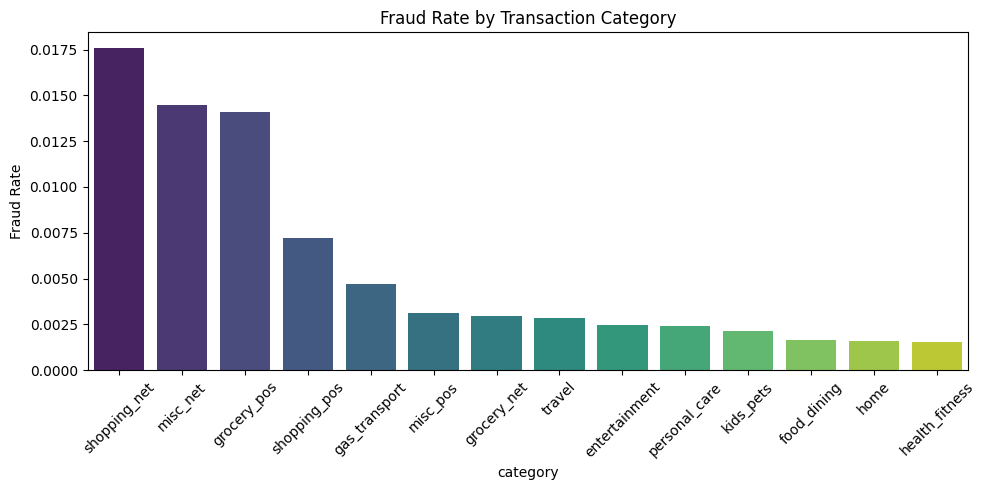

In [14]:
# Fraud rate by category
fraud_rate_by_category = train_df.groupby('category')['is_fraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=fraud_rate_by_category.index, y=fraud_rate_by_category.values, palette='viridis')
plt.xticks(rotation=45)
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Transaction Category")
plt.tight_layout()
plt.show()

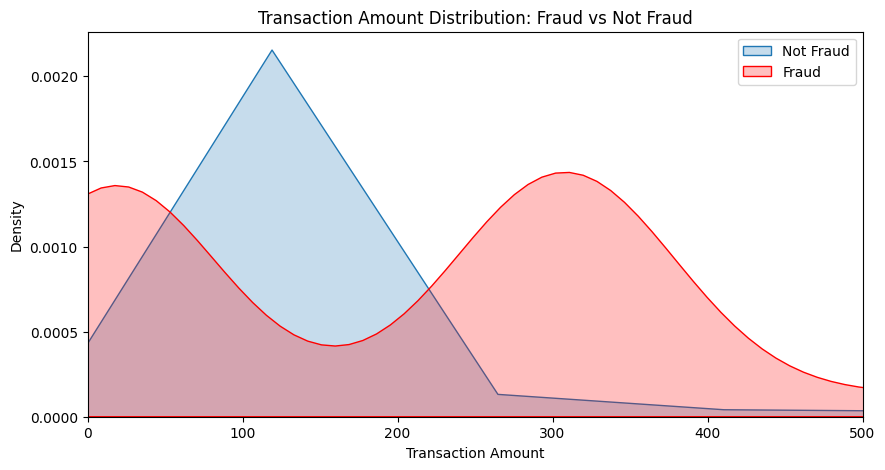

In [13]:
# Distribution of transaction amount
plt.figure(figsize=(10, 5))
sns.kdeplot(data=train_df[train_df['is_fraud'] == 0], x='amt', label='Not Fraud', fill=True)
sns.kdeplot(data=train_df[train_df['is_fraud'] == 1], x='amt', label='Fraud', fill=True, color='red')
plt.xlim(0, 500)
plt.title("Transaction Amount Distribution: Fraud vs Not Fraud")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.legend()
plt.show()

---
### Step 4: Model Training
---

In [15]:
xgb_model = XGBClassifier(
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_processed, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

---
### Step 5: Preprocess and Test on New Data
---

In [16]:
test_df = pd.read_csv("/content/sample_data/fraudTest.csv")
test_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [17]:
test_df.drop('Unnamed: 0', axis=1, inplace=True)

In [18]:
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'])
test_df['dob'] = pd.to_datetime(test_df['dob'])
test_df['trans_hour'] = test_df['trans_date_trans_time'].dt.hour
test_df['day_of_week'] = test_df['trans_date_trans_time'].dt.dayofweek
test_df['age'] = test_df['trans_date_trans_time'].dt.year - test_df['dob'].dt.year
test_df.drop(columns=['cc_num', 'first', 'last', 'street', 'trans_num',
                       'trans_date_trans_time', 'dob'], inplace=True)

In [25]:
X_test = test_df.drop(columns=['is_fraud'])
y_test = test_df['is_fraud']
X_test_processed = preprocessor.transform(X_test)

---
### Step 6: Evaluation & Visualization
---

In [26]:
y_pred = xgb_model.predict(X_test_processed)
y_proba = xgb_model.predict_proba(X_test_processed)[:, 1]

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.9988051515244215

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.91      0.77      0.83      2145

    accuracy                           1.00    555719
   macro avg       0.95      0.89      0.92    555719
weighted avg       1.00      1.00      1.00    555719



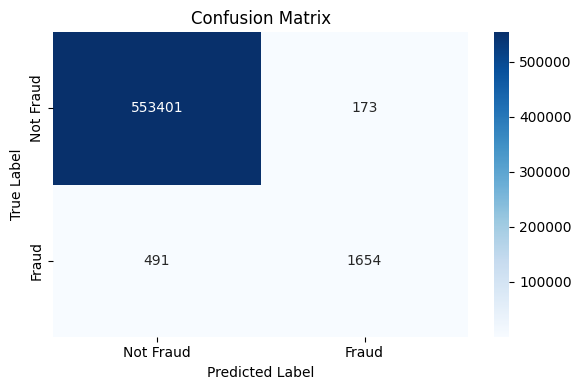

In [21]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
labels = ['Not Fraud', 'Fraud']
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

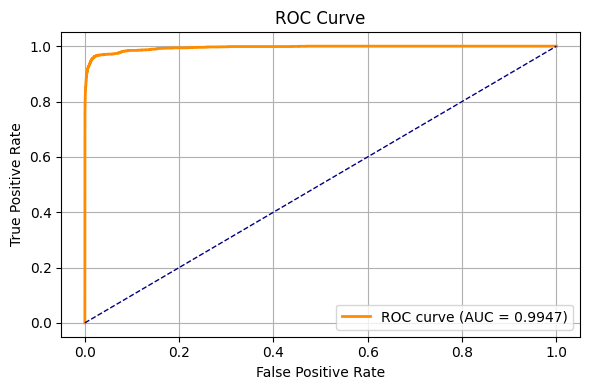

In [22]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

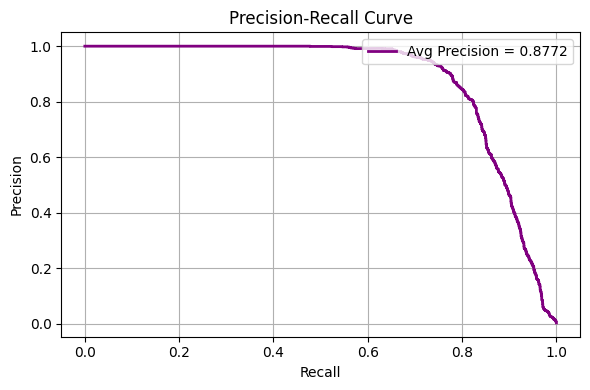

In [23]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='purple', lw=2, label=f'Avg Precision = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

---
### Step 7: Misclassification Insights
---

In [24]:
# False positives: predicted fraud but actually not fraud
false_positives = test_df[(y_test == 0) & (y_pred == 1)]
print(f"False Positives: {len(false_positives)}")

# False negatives: predicted not fraud but actually fraud
false_negatives = test_df[(y_test == 1) & (y_pred == 0)]
print(f"False Negatives: {len(false_negatives)}")

False Positives: 173
False Negatives: 491
